In [1]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
    
import numpy as np
import uproot 
import matplotlib.pyplot as plt
from scipy import stats
from pylab import *
from Python import *

# Detector Calibration 

### The purpose of this notebook is to use python to 'calibrate' the sodium iodide detectors. 

Please refer to the **COMPASS_setup** notebook for instructions on how to collect data.

All fucntions used below are located in **Python.py**

All Figures from this notebook are saved in the **SCREENSHOTS** folder for the detector you're using. 
**Example Directory:** \Users\astropartlab2\Calibration\DAQ\Det_65008-01994\DAQ\Run_190806_Na22_1kV/SCREENSHOTS

**IF YOU RUN THE NOTEBOOK AGAIN IT WILL OVERWRITE ANY PREVIOUS PLOTS> SO MAKE SURE YOU CHANGE THE NAME OF THE OLD PLOT BEFORE RUNNING.**

  

In [2]:
# For detailed information on how to read and manipulate .root files in python see the documetnation locatied here: https://github.com/scikit-hep/uproot
#You will need to change the location of the .root files 

detector = 'Det_65008-01994' #Change for each detector. 
run_ID = 'Run_190806_Na22_1kV' #use same ID use in COMPASS

Energy = []

# the *.root means read any file with the .root extension within this folder. 
for arrays in uproot.iterate("/Users/astropartlab2/Calibration/DAQ/"+str(detector)+"/DAQ/"+str(run_ID)+"/FILTERED/*.root","Data_F;1","Energy",outputtype=list):
#for arrays in uproot.iterate("/Users/Mitch 1/Desktop/Detector_Calibration/Data/Det_65008-01994/Run_07-23-19_Filtered_Data/*.root","Data_F;1","Energy",outputtype=list):    
    for x in arrays: # This iterates through every data point 'x' in 'arrays' and stores the data in an array 'Energy'
        Energy.extend(x)
        


We now need to begin the data fitting procedure. To do so, we need to histogram the data in Energy so that it is in a simliar format as it is in COMPASS

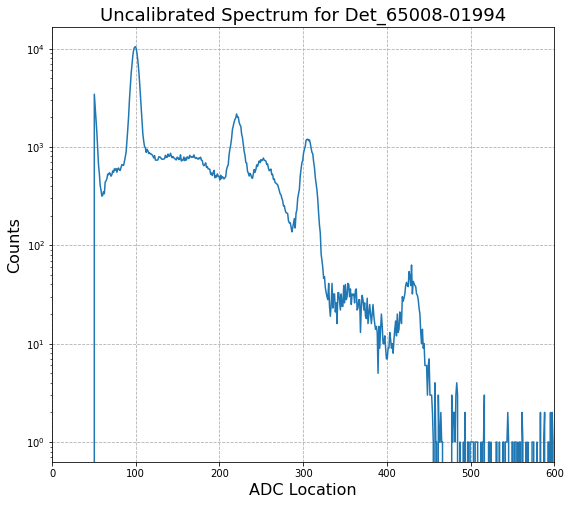

In [3]:
# Histrogram ADC Data 
title = 'Uncalibrated Spectrum'
bin = np.arange(0,max(Energy)) #sets the number of bins 
y,binedges = np.histogram(Energy,bin) #creates histogram from data
bincenters = 0.5*(binedges[1:]+binedges[:-1]) # calculates location of bin centers based on the edges. 


#confirm that histogram looks right. (compare to images taken from COMPASS)
plt.figure(figsize=(9.0,8.0))
plt.plot(bincenters,y)
plt.xlim(0,600)
plt.yscale('log')
plt.xlabel('ADC Location',size = 16)
plt.ylabel('Counts',size = 16)
plt.title('Uncalibrated Spectrum for '+str(detector),size = 18)
plt.grid(which='major',axis= 'both',linestyle='--')
#plt.savefig('Data/'+str(detector)+'/Figures/'+str(title)+'.png')
plt.savefig("/Users/astropartlab2/Calibration/DAQ/"+str(detector)+"/DAQ/"+str(run_ID)+"/SCREENSHOTS/"+str(title)+".png")

plt.show()

Using the histrogramed data, we now need to find the location, amplitude, and width of each on the peaks in ADC. These parameters are what we use to find a calibrated energy spectrum. 
Using a peak finding package from scipy.signal:https://docs.scipy.org/doc/scipy/reference/signal.html , we find an initial ADC loctaion, width, and amplitude to use as initial guess in a peak fitting algorithm. 



In [4]:
# The fucntion 'Peak_locate' is located in 'Python.py'. N represents the number of peaks you wish to fit. This will need to change if you're
# using a source other than Na22, or if you are investigating an unknown peak. 
# The plots below are the results of fitting each peak in ADC. 

# Y = histogrammed data. 
# distance = distance between peaks. Will only look at peaks that are further apart than 'distance' in ADC
# prominance = 'height' of peak. Only looks at peaks with a height greater than 'prominance'
# width = minimum width of peaks to look for. Only looks at peaks with a width greater than 'width'

# The parameters below will need to be adjusted depending on the source you are using. You will need to look at the histogram above to make
# a guess for the parameters. For example, if you wish to fit the last peak, you will need to change N -> 4 and change the prominence to 10**2. 


N = 4 # number of peaks you want to fit. 
distance = 65
prominence =10**1
width = [0,18]

Var_y = y
std_y = np.sqrt(y)
weights_uncal = 1/Var_y


ADC_loc,peaks,widths,amp = Peak_locate(y,distance,prominence,width,bincenters)
print(ADC_loc)




[99.5, 220.5, 305.5, 429.5]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


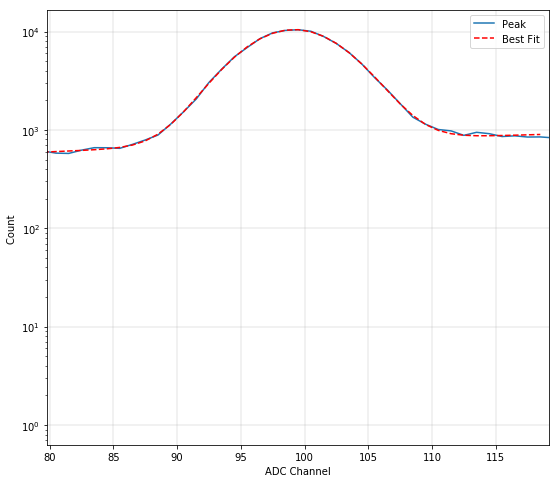

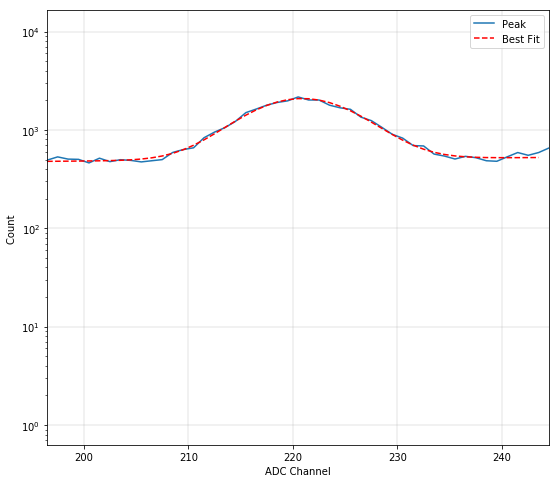

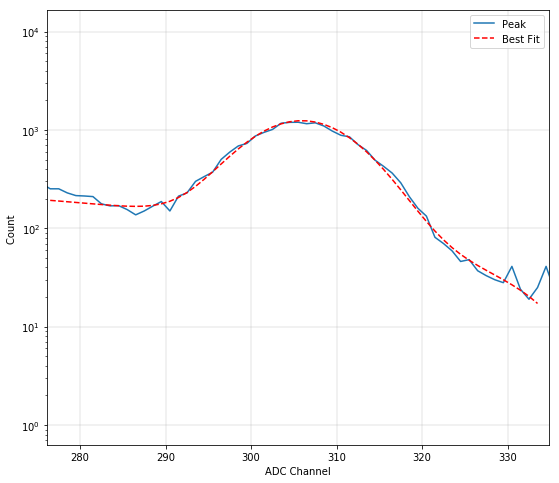

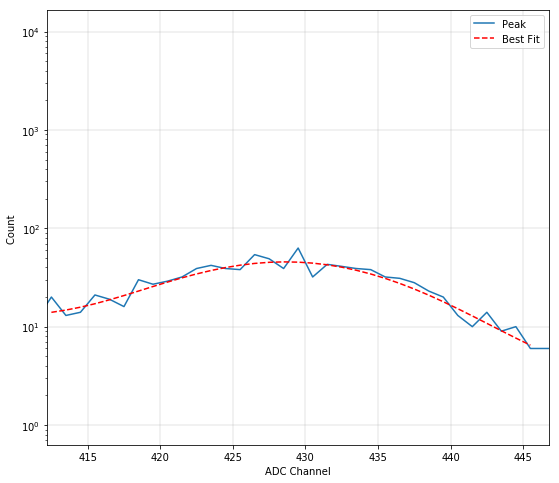

[99.18073715969928, 220.88191258027024, 306.01990994821983, 428.92331426090686]


In [5]:
ADC_center = []
Error_center = []

for i in np.arange(N):
    params = [amp[i],ADC_loc[i],widths[0][i],0,1]
    fit = fit_peak(bincenters, y,params,weights_uncal,'ADC')
    err_cen = fit.params['cen'].stderr #error in the peak location (central value) returned from fit_peak
    Error_center.append(err_cen)       
    ADC_center.append(fit.params['cen'].value)

# If you are having a hard time fitting all desired peaks. You will need to adjust the parameters in the cell above. 
print(ADC_center)

## Calibration Curve

Now that we have peak locations, we need to transform them into units of keV. We do so by using a calibration curve. A calibration curve allows us to analyze the relationship between a measured quantity and its physical representation. Here, we look the expected energy peak vs. the location of the peak in ADC. To 'calibrate' the data, we need to preform a linear regression between the expected peak location in units of keV vs the ADC location. The results of the fit are what will be used to 'calibrate.'

In [6]:
# easy way to switch between desitered peaks (depends on N) . You will need to edit this if you want more peaks or use a different sources. 

EN1 = [511,1274,1785] # Na22 peaks 
EN2 = [511,1274,1785,2614] # Na22 peaks + Tl208 peak 
EN3 = [] # Na22 peaks + Barium peaks 

if N ==3: 
    EN = EN1
    
elif N ==4:
    EN = EN2
else: 
    EN = EN3

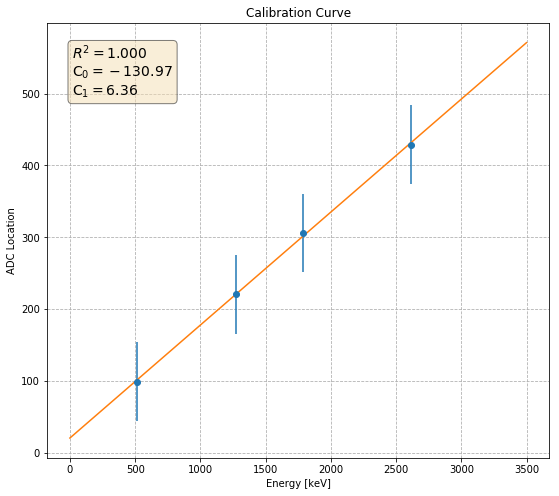

Slope = 6.358137355015694 Intercept = -130.96806422918195 error = 0.002651497877575843


In [7]:
title = 'Calibration Curve' 

#This will make a plot of expected energy vs. ADC_channel location. This is called a 'Calibration Curve.' Code is located in 'Python.py'
#Note the errors are small... so they are presently multiplied by a factor of 100. 
slope,intercept,r_value = Calibration_Curve(ADC_center,Error_center,EN,N,title,detector,run_ID)

The Slope and Intercept returned from the code above have been transformed so that we can find a calibrated energy spectrum. ( slope = 1 / 0.15,  intercept = -19.48/0.15) 

The slope and inercept are what we call 'calibration coefficents.' To get a calibrated spectrum we transform the data: 

$CalibratedEnergy = C_1 * ADC + C_0 $

Here, $C_1$ is the inverse of thslope, ADC is the uncalibrated data, and $C_0$ is the intercept from the fit above. You need to record these values in the notebook as (for example )$C_0 = -129.39$ and $C_1 = 6.64$

We use the equation above to 'transform' the data into units of energy [keV]. The code below does that, and plots the new calibrated spectrum. 

[ 498.48753392 1267.82215387 1814.62196641 2590.31472372]


C:\Users\astropartlab2\Desktop\Detector_Cal\Python.py:253: RuntimeWarning: divide by zero encountered in true_divide
  Weights = 1/y1  # New weights


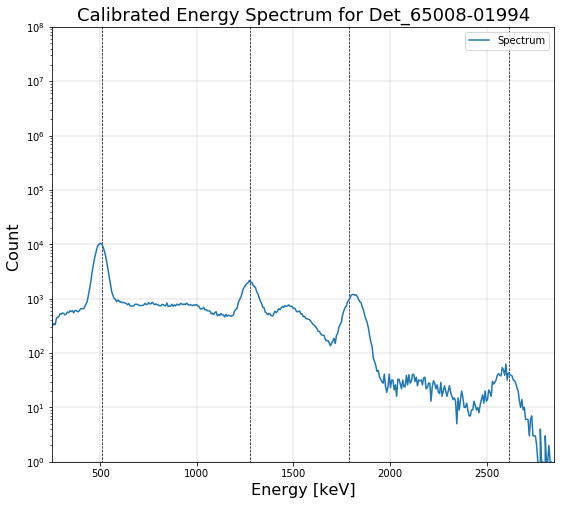

In [8]:
# Calibrate Data and Plot New Spectrum. 

y1, bincenters, Center, Width, Amplitude, Weights = Calibrate_linear(Energy,ADC_center,peaks,widths,bin,slope,intercept)

title = 'Calibrated Spectrum'

plt.figure(figsize=(9.0,8.0))
plt.plot(bincenters,y1,label = 'Spectrum')

for x in EN: # This plots where the peaks should be located after the calibration 
        plt.vlines(x,0,10**9,linestyle='--', linewidth=0.7)

plt.title('Calibrated Energy Spectrum for '+str(detector),size = 18)
plt.xlabel("Energy [keV]",size = 16)
plt.xlim(250,2850)
plt.ylabel("Count ",size = 16)
plt.ylim(1,10**8)
plt.yscale('log')
plt.grid(linestyle='-', linewidth=0.35)
plt.legend() 

plt.savefig("/Users/astropartlab2/Calibration/DAQ/"+str(detector)+"/DAQ/"+str(run_ID)+"/SCREENSHOTS/"+str(title)+".png")
plt.show()

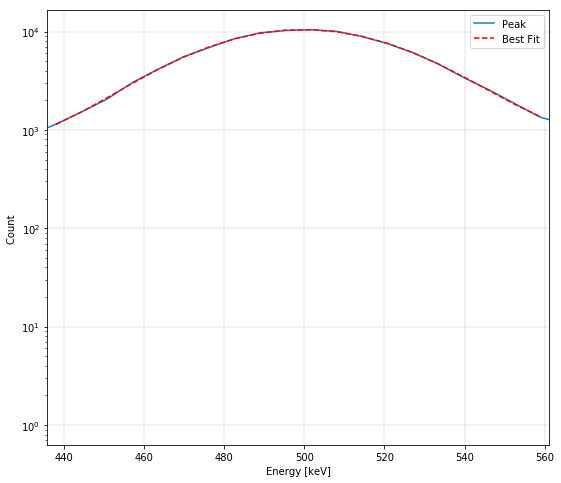

Fit Results for the  511 keV peak
[[Model]]
    (Model(gaussian) + Model(line))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 20
    # variables        = 5
    chi-square         = 0.00320526
    reduced chi-square = 2.1368e-04
    Akaike info crit   = -164.773895
    Bayesian info crit = -159.795234
[[Variables]]
    amp:        9768.43943 +/- 55.4979196 (0.57%) (init = 10446), model_value = 9768.439
    cen:        499.739463 +/- 0.13293391 (0.03%) (init = 498.4875), model_value = 499.7395
    wid:        25.0316276 +/- 0.16206917 (0.65%) (init = 31.31814), model_value = 25.03163
    slope:      0.82505106 +/- 0.25950648 (31.45%) (init = 5), model_value = 0.8250511
    intercept:  306.579961 +/- 125.465169 (40.92%) (init = 10), model_value = 306.58
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.977
    C(cen, slope)       = -0.771
    C(cen, intercept)   =  0.763
    C(amp, wid)         = 

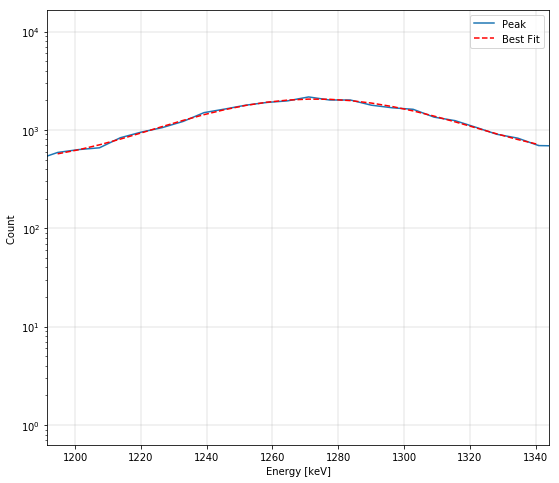

Fit Results for the  1274 keV peak
[[Model]]
    (Model(gaussian) + Model(line))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 24
    # variables        = 5
    chi-square         = 0.02266864
    reduced chi-square = 0.00119309
    Akaike info crit   = -157.155844
    Bayesian info crit = -151.265575
[[Variables]]
    amp:        1574.68761 +/- 34.3723849 (2.18%) (init = 2164), model_value = 1574.688
    cen:        1273.01748 +/- 0.75353678 (0.06%) (init = 1267.822), model_value = 1273.017
    wid:        33.7259354 +/- 1.09302336 (3.24%) (init = 38.16882), model_value = 33.72594
    slope:      0.25847926 +/- 0.26061090 (100.82%) (init = 5), model_value = 0.2584793
    intercept:  156.289462 +/- 313.007340 (200.27%) (init = 10), model_value = 156.2895
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.995
    C(cen, intercept)   =  0.837
    C(cen, slope)       = -0.834
    C(amp, wid)       

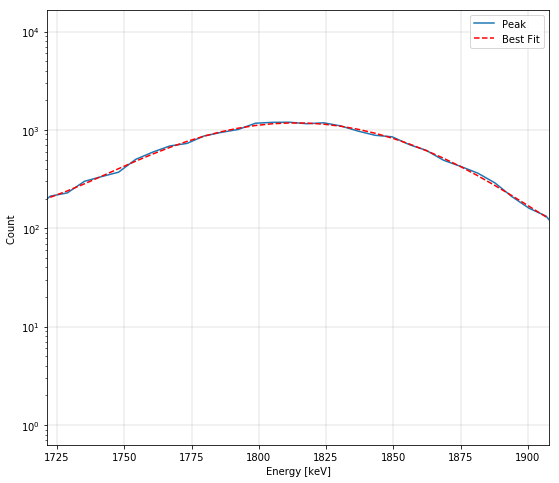

Fit Results for the  1785 keV peak
[[Model]]
    (Model(gaussian) + Model(line))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 30
    # variables        = 5
    chi-square         = 0.04477314
    reduced chi-square = 0.00179093
    Akaike info crit   = -185.220331
    Bayesian info crit = -178.214344
[[Variables]]
    amp:        1098.86402 +/- 14.9785855 (1.36%) (init = 1197), model_value = 1098.864
    cen:        1814.25135 +/- 0.58658125 (0.03%) (init = 1814.622), model_value = 1814.251
    wid:        41.0638679 +/- 0.80004152 (1.95%) (init = 46.68163), model_value = 41.06387
    slope:     -0.39375913 +/- 0.06462800 (16.41%) (init = 5), model_value = -0.3937591
    intercept:  794.563360 +/- 121.233735 (15.26%) (init = 10), model_value = 794.5634
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.996
    C(cen, slope)       = -0.826
    C(cen, intercept)   =  0.818
    C(wid, intercept)  

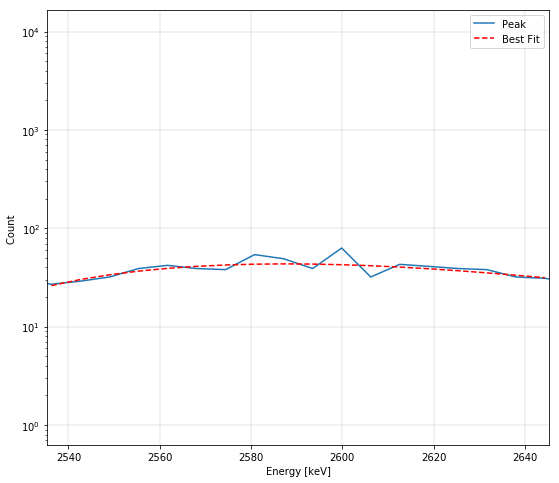

Fit Results for the  2614 keV peak
[[Model]]
    (Model(gaussian) + Model(line))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 18
    # variables        = 5
    chi-square         = 0.30628002
    reduced chi-square = 0.02356000
    Akaike info crit   = -63.3252904
    Bayesian info crit = -58.8734316
[[Variables]]
    amp:        71.6445705 +/- 514.220125 (717.74%) (init = 63), model_value = 71.64457
    cen:        2564.31966 +/- 160.615294 (6.26%) (init = 2590.315), model_value = 2564.32
    wid:        71.9644236 +/- 252.787929 (351.27%) (init = 27.49821), model_value = 71.96442
    slope:      0.30646908 +/- 2.06276244 (673.07%) (init = 5), model_value = 0.3064691
    intercept: -817.546206 +/- 5795.72939 (708.92%) (init = 10), model_value = -817.5462
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -1.000
    C(cen, intercept)   =  0.999
    C(cen, slope)       = -0.999
    C(amp, wid)     

In [9]:
# Need to fit the Calibrated Spectrum


wid = [] 
wid_error = []
cen = []
amp = []

# Takes calibrated parameters: peak amplitide, peak location, and peak width, and uses them as intial guessses for the fit_peak algorithim. 
for i in np.arange(len(ADC_loc)):
    params1 = [Amplitude[i],Center[i],Width[i]/2,5,10]    
    fit = fit_peak(bincenters,y1,params1,Weights,input)

    print('Fit Results for the ', EN[i],'keV peak')
    
    print(fit.fit_report(fit.params))
 #   for key in fit.params:
 #       print(key, "=", "{0:.2f}".format(fit.params[key].value), "+/-", "{0:.2f}".format(fit.params[key].stderr)) # Prints the results, and the error in the results in each fit. 

    #storing values to be used later.     
    wid.append(np.abs(fit.params['wid'].value))
    wid_error.append((fit.params['wid'].stderr))
    cen.append(np.abs(fit.params['cen'].value))
    amp.append(np.abs(fit.params['amp'].value))



# Relative Error in peak Location

 Relative error is also known as relative uncertainty or approximation error. It is a measure of the uncertainty of measurement compared to the size of the measurement. It's used to put error into perspective.
The relative error is defined as: 
 $$Error = \frac{|X-\hat{X}|}{X}$$
 Where $X$ is the expected value and $\hat{X}$ is the measured value. 


In [10]:
center =[]

for x in Center: 
       m = float("{0:.2f}".format(x))
       center.append(m)

print('Expected peak location in Energy is: ',EN)
print('Fitted peak location in Energy is: ',center)


for c,e in zip(Center,EN):

        percent_diff = np.abs(c-e)/(e) * 100
        print('Relative Error in the peak location for ' +str(e)+' is: ',"{0:.2f}".format(percent_diff),'%')

Expected peak location in Energy is:  [511, 1274, 1785, 2614]
Fitted peak location in Energy is:  [498.49, 1267.82, 1814.62, 2590.31]
Relative Error in the peak location for 511 is:  2.45 %
Relative Error in the peak location for 1274 is:  0.48 %
Relative Error in the peak location for 1785 is:  1.66 %
Relative Error in the peak location for 2614 is:  0.91 %


# Peak Resolution
Peak Resolution refers to the ability to separate two or more objects that are close together in space. A common way to represent the resoultion is through the use of 'Full Width at Half Maximum' or FWHM. 

FWHM is the width of a peak at half of its maximum amplitude. For Gaussians, the FWHM is about 2.4 standard deviations. While the concept is simple, this is a vital quantity; the FWHM is used to define resolution.

If two peaks have overlapping FWHMs, they are unresolvable, i.e. they will look like one peak.

$$FWHM = 2\sigma\sqrt{2 ln2}$$

For an example, if the $FWHM = 53.4 keV$ at $500 keV$ this would mean that at $500 keV$ we would be able to resolve peaks that were greater than or equal to $53.4 keV$ apart.

A common way in which the resolution is reproted is 'Pulse Height Resolution.' PHR is defined as the FWHM divided by the mean energy of the peak of interest. 

$$PHR = \frac{FWHM}{E_n}$$

In [11]:
FWHM = []
for w,e,er in zip(wid,EN,wid_error):
        fwhm = 2*w*np.sqrt(np.log(2))
        FWHM.append(fwhm)
        res = fwhm/(e) * 100 
        print('FWHM for ' +str(e)+ ' keV is: ' ,"{0:.2f}".format(fwhm),'±',"{0:.2f}".format(er))
        print('Pulse Height Resolution for ' +str(e)+ ' keV is: ' ,"{0:.2f}".format(res),'%')


#%%
print(width)

FWHM for 511 keV is:  41.68 ± 0.16
Pulse Height Resolution for 511 keV is:  8.16 %
FWHM for 1274 keV is:  56.16 ± 1.09
Pulse Height Resolution for 1274 keV is:  4.41 %
FWHM for 1785 keV is:  68.38 ± 0.80
Pulse Height Resolution for 1785 keV is:  3.83 %
FWHM for 2614 keV is:  119.83 ± 252.79
Pulse Height Resolution for 2614 keV is:  4.58 %
[0, 18]


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Det_65008-01994/Figures/Detector Resolution For Det_65008-01994.png'

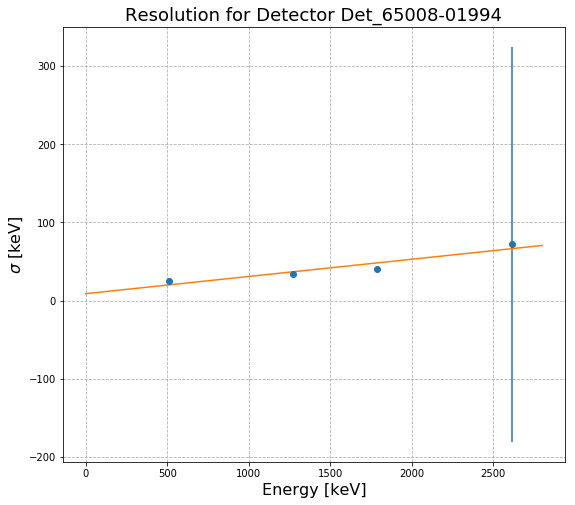

In [12]:
slope, intercept, r_value, p_value, std_err = stats.linregress(EN,wid)
l = [0,2800]
fit = []
for x in l:
    y = slope*x + intercept
    fit.append(y) 
    
title = 'Detector Resolution For ' +str(detector)

plt.figure(figsize=(9.0,8.0))
plt.errorbar(EN,wid,yerr=wid_error,fmt ='o')
plt.plot(l,fit,label='y={:.2f}x + {:.2f}'.format(slope,intercept))#plt.scatter(EN,FWHM)
plt.title('Resolution for Detector '+str(detector),size = 18)
plt.ylabel('$\sigma$ [keV]',size = 16)
plt.xlabel('Energy [keV]',size = 16)
plt.grid(which='major',axis= 'both',linestyle='--')
plt.savefig('Data/'+str(detector)+'/Figures/'+str(title))
plt.legend(('r={:.3f}'.format(r_value),'data'))
plt.show()

print('m ={:.3f}'.format(slope),'+\- {:.3f}'.format(std_err),' b = {:.3f}'.format(intercept))